If you're trying to analyze algorithms, you need a metric. Performance information can be very informative -
it's like a 'score' for algorithms. However, picking the right performance metric can be a challenge.

The first thing that (probably) comes to mind is **time**. If a program takes longer to run than its competitor for the same result, you
could say that the competitor is "more performant" because it runs faster.

To try this out, I have three sorting algorithms: bubble sort, selection sort, and mergesort.

In [1]:
import general
from caching import update_required, prep, save, load_previous

import sys
import copy
import math

# Initialize caching backend
prep()

#### got `ImportError`s?
You should have at least a copy of `caching.py` and `general.py`. If you don't, go download them [Github](https://github.com/penguinencounter/sorting-algorithms)
and make sure they're in the same directory as this notebook.

In [2]:
# Dataset generator configuration
REPS = 8
SEED = 2

RUN_ALL_MODE = True  # disables optional algorithm runs

In [3]:
# Provides dataset sizes.
def size_provider():
    yield 0  # required for benchmark to determine total size of datasets
    i = 1
    while 1:
        yield round(i)
        i *= 4/3
        if i > 5000:
            break


In [4]:
datasets = general.generate_testing_data(list(size_provider()), REPS, SEED, quiet=2)
edges = general.generate_edge_cases(list(size_provider()), quiet=2)

results = {}
edge_results = {}

Generating testing data. This may take a while.
Need to generate 248 total datasets
generated 248 datasets in 0.13s                                                                     
Generating edge cases.
Generators:
   - sorted
   - reversed
   - all_eq
done, took 0.03s                                                                                    


In [5]:
# Use timeit API to run benchmark
import timeit
def autorun_time(f, datasets, seed, fn=""):
    fname = f + fn + "_time"
    if update_required(fname, seed):
        print(f"Running benchmark for {fname}")
        all_results = {}
        for size, sets in datasets.items():
            result = timeit.repeat(
                f"""
for i, a in enumerate(b):
    {f}(a)
    print(('\\rrep' + str(i+1) + ' of ' + str(len(b)) + ' (size='+str(size)+')').ljust(50), end='', flush=True)
                """,
                f"from __main__ import {f}; b={str(sets)}; size={size}",
                number=1
            )
            all_results[size] = result[0]
        save(fname, seed, all_results)
        print("Finished / saved")
        return all_results
    else:
        print(f"Retrieving {fname} from cache")
        return load_previous(fname, seed)
        

In [6]:
# Use returned check/swap stats from function
def autorun_or_cache(f, fname, datasets, seed, quiet=1):
    if update_required(fname, seed):
        print(f'Cache missed for {fname}')
        try:
            result = general.bench(f, datasets, quiet=quiet)
            save(fname, seed, result)
            print(f'Saved {fname} to cache')
        except RecursionError:
            print(f'!! Recursion depth limit reached - cancelling !!')
            return 0, 0
        return result
    else:
        print(f'Cache hit for {fname}')
        print(f'Retrieving {fname} from cache')
        return load_previous(fname, seed)

In [7]:
def run_edge_cases(f, fname, edges, seed, quiet=1):
    result = {}
    for k, v in edges.items():
        result[k] = autorun_or_cache(f, fname + "_edge_" + k, v, seed, quiet)
    print("Done!")
    return result

## Plotting stuff

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def axis_config(ax, xlabel, ylabel):
    # disable scientific notation and offsets
    ax.ticklabel_format(useOffset=False, style='plain')
    
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)

In [10]:
def graph_eq(func, x_range, ax, label='Function'):
    x = np.array(x_range)
    y = func(x)
    ax.plot(x, y, label=label)

Bubble sort works in "passes".

Each pass goes through the data, and if the current element is more than the next one, it switches them.

It's done when no changes are made in a "pass".

In [11]:
def bubble(a: list):
    chks = 0
    swps = 0
    data = copy.copy(a)
    n = len(data)
    while 1:
        swapped = False
        for i in range(n-1):
            chks += 1
            if data[i] > data[i+1]:
                general.swp(data, i, i+1)
                swapped = True
                swps += 1
        if not swapped: break
    return data, swps, chks

### The below cell will run Bubble Sort. It *will* take a long time and is completely optional.
Delete "bubble_time_2.pkl" to clear cache for this cell

In [12]:
# MANUAL RUN MODE
if not RUN_ALL_MODE:
    result = input("Are you sure you want to do this? This will take a VERY LONG TIME. [y/N]")
    if result == 'y':
        autorun_time("bubble", datasets, SEED)
    else:
        print('cancelled')
else:
    print('Disabled due to RUN_ALL_MODE')

Disabled due to RUN_ALL_MODE


In [13]:
# Actual data retrieval
result = autorun_time("bubble", datasets, SEED, fn="_lowload")
print(result)

Retrieving bubble_lowload_time from cache
{0: 0.002484599999999837, 1: 0.0025663000000002434, 2: 0.002311300000000127, 3: 0.0024999999999999467, 4: 0.002728400000000075, 6: 0.002517399999999892, 7: 0.0024092000000002223, 10: 0.0025985999999997844, 13: 0.002820600000000173, 18: 0.0028005000000002056, 24: 0.0031281999999999144, 32: 0.004193200000000008, 42: 0.005200400000000105, 56: 0.007514599999999927, 75: 0.010902499999999815, 100: 0.017019100000000176, 133: 0.02719870000000002, 177: 0.04795390000000044, 237: 0.08641579999999927, 315: 0.14440600000000003, 420: 0.24740170000000017, 561: 0.4417049000000004, 747: 0.8311671, 997: 1.5032115000000008, 1329: 2.7217269, 1772: 4.813648399999998, 2362: 8.546572300000001, 3150: 15.064273600000007, 4200: 26.667877799999985}


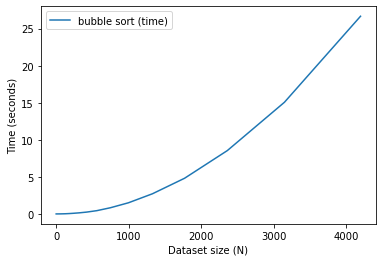

In [14]:
fig, ax = plt.subplots()
ax.plot(result.keys(), result.values(), label="bubble sort (time)")
ax.legend()
axis_config(ax, "Dataset size (N)", "Time (seconds)")

Bubble sort has $O(N^2)$ average performance. This is called "big $O$ notation" and it's basically a function that describes how performance
worsens when the dataset's size increases. $O(N^2)$ is called "polynomial time" because $f(N)=N^2$ is a polynomial function. So, let's plot $y=x^2$ on the graph too:

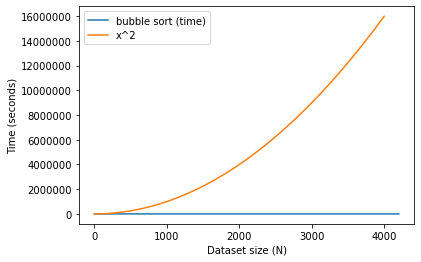

In [15]:
fig, ax = plt.subplots()
ax.plot(result.keys(), result.values(), label="bubble sort (time)")
graph_eq(lambda x: x**2, range(0, 4000), ax, label="x^2")
ax.legend()
axis_config(ax, "Dataset size (N)", "Time (seconds)")
# This code does not work. Do not use this.

We need to fit the $x^2$ curve to the data. (A fixed multiplier does not change the $O(N...)$ result. It's still
polynomial time).

After using Desmos to perform the regression, we get $b=0.00000151516056997$ as in $b \times x^2$

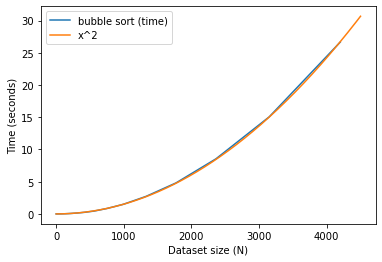

In [16]:
fig, ax = plt.subplots()
ax.plot(result.keys(), result.values(), label="bubble sort (time)")
b = 0.00000151516056997
graph_eq(lambda x: b*x**2, range(0, 4500), ax, label="x^2")
ax.legend()
axis_config(ax, "Dataset size (N)", "Time (seconds)")

Okay, that looks better.

However, look what happens when we try running it again, with an intesive app (like a game, in this case)
running in the background.

In [17]:
# High load data.
result2 = autorun_time("bubble", datasets, SEED, fn="_highload")
print(result2)

Retrieving bubble_highload_time from cache
{0: 0.003095500000000584, 1: 0.0033263000000118836, 2: 0.0030187999999924386, 3: 0.0021983999999974912, 4: 0.0025266000000101485, 6: 0.0024698000000000775, 7: 0.0024918000000013762, 10: 0.002831100000008746, 13: 0.003569900000002235, 18: 0.0027268999999989774, 24: 0.04421999999999571, 32: 0.0039464999999978545, 42: 0.005051100000002862, 56: 0.007948300000009567, 75: 0.011160399999994297, 100: 0.05790740000000483, 133: 0.028200200000000564, 177: 0.04977340000000652, 237: 0.09091750000000332, 315: 0.15193610000000035, 420: 0.2666662000000031, 561: 0.46626249999999914, 747: 0.8620546999999874, 997: 1.5655056999999886, 1329: 3.3284525999999914, 1772: 13.927456699999993, 2362: 11.27935740000001, 3150: 17.825116500000007, 4200: 29.587912200000005}


Let's reuse the previous code - it should have the same result?

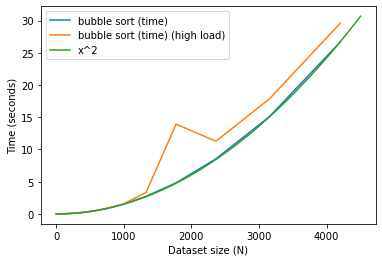

In [18]:
fig, ax = plt.subplots()
ax.plot(result.keys(), result.values(), label="bubble sort (time)")
ax.plot(result2.keys(), result2.values(), label="bubble sort (time) (high load)")
b = 0.00000151516056997
graph_eq(lambda x: b*x**2, range(0, 4500), ax, label="x^2")
ax.legend()
axis_config(ax, "Dataset size (N)", "Time (seconds)")

As you can see, the time stat is very susceptible to other external influences. For this extreme effect, I launched 3 instances of Minecraft, and joined servers.

So, what other statistics could we use? We'll switch to using *selection sort* for this next part. *Selection sort should be $O(N^2)$ as well.*

Selection sort repeatedly finds the lowest element in the data and moves it to the beginning (dividing the array into "sorted" and "unsorted"
sections in the process)

In [19]:
def selection(a: list):
    chks = 0
    swps = 0
    data = copy.copy(a)
    n = len(data)
    for i in range(n):
        m = i
        for j in range(i+1, n):
            chks += 1
            if data[m] >= data[j]:
                m = j
        swps += 1
        general.swp(data, i, m)
    return data, swps, chks

### OPTIONAL Manual run for Selection Sort
Delete the 'selection_2.pkl' file to re-run this.

In [20]:
if not RUN_ALL_MODE:
    result = input("Are you sure you want to do this? This will take a medium amount of time. [y/N]")
    if result == 'y':
        autorun_or_cache(selection, "selection", datasets, SEED)
    else:
        print('cancelled')
else:
    print('Disabled due to RUN_ALL_MODE')

Disabled due to RUN_ALL_MODE


Let's test this.

In [21]:
result3, _ = autorun_or_cache(selection, "selection_ex", datasets, SEED)  # Discard second result data, soon(tm)
print(result3)  # Array writes

Cache hit for selection_ex
Retrieving selection_ex from cache
{0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 6: 6.0, 7: 7.0, 10: 10.0, 13: 13.0, 18: 18.0, 24: 24.0, 32: 32.0, 42: 42.0, 56: 56.0, 75: 75.0, 100: 100.0, 133: 133.0, 177: 177.0, 237: 237.0, 315: 315.0, 420: 420.0, 561: 561.0, 747: 747.0, 997: 997.0, 1329: 1329.0, 1772: 1772.0, 2362: 2362.0, 3150: 3150.0, 4200: 4200.0}


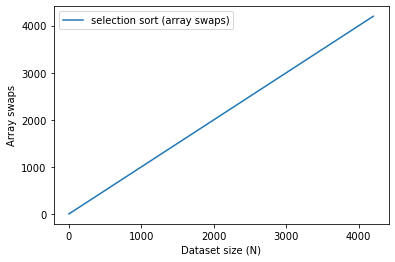

In [22]:
fig, ax = plt.subplots()
ax.plot(result3.keys(), result3.values(), label="selection sort (array swaps)")
ax.legend()
axis_config(ax, "Dataset size (N)", "Array swaps")

Well that's *linear*.

Selection sort was $O(N^2)$?

Obviously this is wrong, but there's more:
this doesn't show very well that Selection sort actually ends up spending most of its time
looking through the array for the lowest element.

Just for fun, here's what happens when you fit $y=ax^2$ to the data:

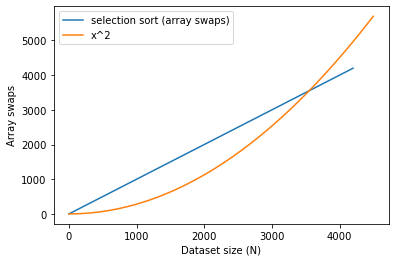

In [23]:
fig, ax = plt.subplots()
ax.plot(result3.keys(), result3.values(), label="selection sort (array swaps)")
b = 0.000281530859597
graph_eq(lambda x: b*x**2, range(0, 4500), ax, label="x^2")
ax.legend()
axis_config(ax, "Dataset size (N)", "Array swaps")

### The actual "good" metric
So we have two metrics that don't work. So what's the correct one?

Comparison count. Doing a comparison usually involves, even at a low level, a significant amount of compute power.
*(aside: this is why [branch prediction](https://en.wikipedia.org/wiki/Branch_predictor) exists.)*
This makes comparison count a good performance measure that isn't very volatile.

Let's apply this to selection sort...

In [24]:
_, result4 = autorun_or_cache(selection, "selection_ex", datasets, SEED)  # Here's the second result data!
print(result4)  # Comparison count

Cache hit for selection_ex
Retrieving selection_ex from cache
{0: 0.0, 1: 0.0, 2: 1.0, 3: 3.0, 4: 6.0, 6: 15.0, 7: 21.0, 10: 45.0, 13: 78.0, 18: 153.0, 24: 276.0, 32: 496.0, 42: 861.0, 56: 1540.0, 75: 2775.0, 100: 4950.0, 133: 8778.0, 177: 15576.0, 237: 27966.0, 315: 49455.0, 420: 87990.0, 561: 157080.0, 747: 278631.0, 997: 496506.0, 1329: 882456.0, 1772: 1569106.0, 2362: 2788341.0, 3150: 4959675.0, 4200: 8817900.0}


In [25]:
print(list(result4.keys()))
print(list(result4.values()))

[0, 1, 2, 3, 4, 6, 7, 10, 13, 18, 24, 32, 42, 56, 75, 100, 133, 177, 237, 315, 420, 561, 747, 997, 1329, 1772, 2362, 3150, 4200]
[0.0, 0.0, 1.0, 3.0, 6.0, 15.0, 21.0, 45.0, 78.0, 153.0, 276.0, 496.0, 861.0, 1540.0, 2775.0, 4950.0, 8778.0, 15576.0, 27966.0, 49455.0, 87990.0, 157080.0, 278631.0, 496506.0, 882456.0, 1569106.0, 2788341.0, 4959675.0, 8817900.0]


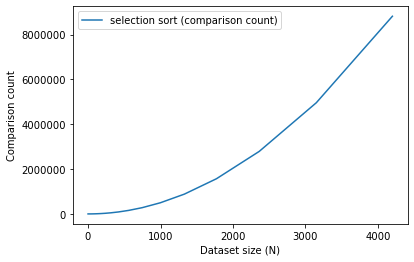

In [26]:
fig, ax = plt.subplots()
ax.plot(result4.keys(), result4.values(), label="selection sort (comparison count)")
ax.legend()
axis_config(ax, "Dataset size (N)", "Comparison count")

($x^2$ w/ regression)

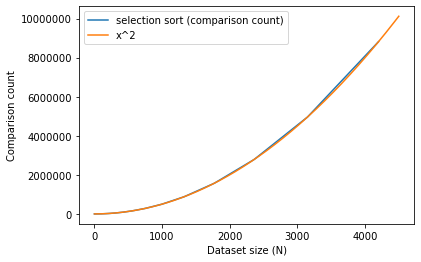

In [27]:
fig, ax = plt.subplots()
ax.plot(result4.keys(), result4.values(), label="selection sort (comparison count)")
b = 0.49985923457
graph_eq(lambda x: b*x**2, range(0, 4500), ax, label="x^2")
ax.legend()
axis_config(ax, "Dataset size (N)", "Comparison count")

Looks good! Let's try mergesort too:

Mergesort is a "recursive" algorithm. That means that (very bluntly) the function calls itself.
It splits the list in half repeatedly, and then `merge()`s them back together.

Oh and it's $O(N log N)$. This is "quasilinear" time and it's generally better than polynomial time.

In [28]:
def merge(a: list, b: list):
    result = []
    checks = 0
    swaps = 0
    while len(a) > 0 and len(b) > 0:
        checks += 1
        if a[0] < b[0]:
            result.append(a.pop(0))
        else:
            result.append(b.pop(0))
        swaps += 1

    # Consume rest
    while len(a) > 0:
        result.append(a.pop(0))
        swaps += 1
    while len(b) > 0:
        result.append(b.pop(0))
        swaps += 1
    return result, checks, swaps


def mergesort(m: list):
    if len(m) <= 1:
        return m, 0, 0

    left = []
    right = []
    for i, x in enumerate(m):
        if i < len(m) // 2:
            left.append(x)
        else:
            right.append(x)

    left, c1, s1 = mergesort(left)  # RECURSION!
    right, c2, s2 = mergesort(right)

    r, c3, s3 = merge(left, right)

    checks = c1 + c2 + c3
    swaps = s1 + s2 + s3
    return r, checks, swaps

In [29]:
_, result5 = autorun_or_cache(mergesort, "mergesort_ex", datasets, SEED, quiet=1)

Cache hit for mergesort_ex
Retrieving mergesort_ex from cache


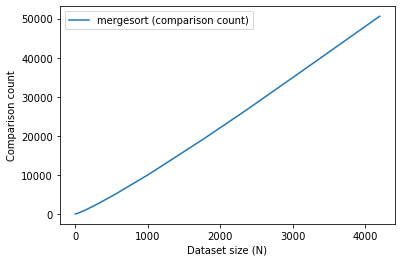

In [30]:
fig, ax = plt.subplots()
ax.plot(result5.keys(), result5.values(), label="mergesort (comparison count)")
ax.legend()
axis_config(ax, "Dataset size (N)", "Comparison count")

I guess "quasilinear" makes sense?

<ipython-input-31-b9c1b2ee3263>:4: RuntimeWarning: divide by zero encountered in log
  graph_eq(lambda x: b*(x*np.log(x)), range(0, 4200), ax, label="x log x")
<ipython-input-31-b9c1b2ee3263>:4: RuntimeWarning: invalid value encountered in multiply
  graph_eq(lambda x: b*(x*np.log(x)), range(0, 4200), ax, label="x log x")


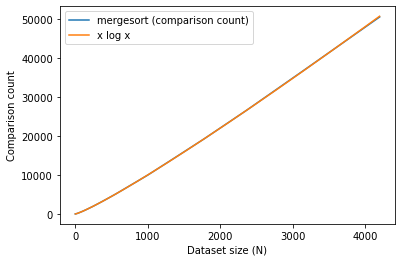

In [31]:
fig, ax = plt.subplots()
ax.plot(result5.keys(), result5.values(), label="mergesort (comparison count)")
b = 1.45  # rough estimate
graph_eq(lambda x: b*(x*np.log(x)), range(0, 4200), ax, label="x log x")
ax.legend()
axis_config(ax, "Dataset size (N)", "Comparison count")

Combine all algorithms on the same graph:

In [32]:
# Still need bubblesort data!
_, fresult1 = autorun_or_cache(bubble, "bubble_ex", datasets, SEED)
fresult2 = result4 # copy of Selection
fresult3 = result5 # copy of Merge

Cache hit for bubble_ex
Retrieving bubble_ex from cache


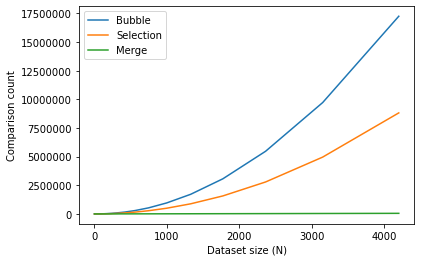

In [33]:
fig, ax = plt.subplots()
ax.plot(fresult1.keys(), fresult1.values(), label="Bubble")
ax.plot(fresult2.keys(), fresult2.values(), label="Selection")
ax.plot(fresult3.keys(), fresult3.values(), label="Merge")
ax.legend()
axis_config(ax, "Dataset size (N)", "Comparison count")

### Conclusion

Use comparison count as your performance metric. It's the metric most professionals use and
is more reliable than other metrics, like time.

Of course, sometimes it's hard to calculate comparison count, like when you don't control all of the code in your program (libraries, builtins, etc.) However, for relative comparisons, what you have *should* be good enough.

by PenguinEncounter 2022. See LICENCE for license information. 